In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from tensorflow.keras.datasets import mnist
from keras.layers import *
from keras.models import *
from keras.losses import *
from keras.callbacks import *
from keras.optimizers import *
from keras import backend as K
import tensorflow as tf
from tensorflow.keras import layers, Model

Missing Data Schemes (MCAR, MNAR1, MNAR2, MNAR3)

In [ ]:
def REMOVE(data, frac, mechanism='MCAR'):
    n, rows, cols = data.shape
    num_missing = int(rows * cols * frac)
    data_final = data.copy()
    for i in range(n):
        if mechanism == 'MCAR':
            missing_indices = np.random.choice(rows * cols, num_missing, replace=False)
        elif mechanism == 'MNAR':
            flat_image = data_final[i].flatten()
            sort_ind = np.argsort(flat_image)
            threshold_index = int(rows * cols * 0.5)
            above_thres_ind = sort_ind[threshold_index:]
            num_above_thres = len(above_thres_ind)
            num_miss_above_thres = min(num_missing, num_above_thres // 2)
            missing_indices = np.random.choice(above_thres_ind, num_miss_above_thres, replace=False)
        elif mechanism == 'MNAR1':
            square_rows, square_cols = rows // 4, cols // 4
            num_squares = 16
            num_squares_to_remove = min(16, max(1, round(frac * 16)))
            squares_to_remove = np.random.choice(num_squares, num_squares_to_remove, replace=False)
            missing_indices = []
            for square in squares_to_remove:
                start_row = (square // 4) * square_rows
                start_col = (square % 4) * square_cols
                for r in range(start_row, start_row + square_rows):
                    missing_indices.extend(range(r * cols + start_col, r * cols + start_col + square_cols))
            if len(missing_indices) > num_missing:
                missing_indices = np.random.choice(missing_indices, num_missing, replace=False)
        elif mechanism == 'MNAR2':
            num_strips = min(4, max(1, round(frac * 4)))
            strip_height = rows // 4
            strips_to_remove = np.random.choice(4, num_strips, replace=False)
            missing_indices = []
            for strip in strips_to_remove:
                start_row = strip * strip_height
                end_row = start_row + strip_height
                for row in range(start_row, end_row):
                    missing_indices.extend(range(row * cols, (row + 1) * cols))
            if len(missing_indices) > num_missing:
                missing_indices = np.random.choice(missing_indices, num_missing, replace=False)
        elif mechanism == 'MNAR3':
            square_rows, square_cols = 2, 2
            num_squares = (rows // square_rows) * (cols // square_cols)
            num_squares_to_remove = min(num_squares, max(1, round(frac * num_squares)))
            squares_to_remove = np.random.choice(num_squares, num_squares_to_remove, replace=False)
            missing_indices = []
            for square in squares_to_remove:
                start_row = (square // (cols // square_cols)) * square_rows
                start_col = (square % (cols // square_cols)) * square_cols
                for r in range(start_row, start_row + square_rows):
                    missing_indices.extend(range(r * cols + start_col, r * cols + start_col + square_cols))
            if len(missing_indices) > num_missing:
                missing_indices = np.random.choice(missing_indices, num_missing, replace=False)

        data_final[i, [idx // cols for idx in missing_indices], [idx % cols for idx in missing_indices]] = np.nan
    return data_final

Traditional Imputation Schemes

In [ ]:
def IMPUTE(data_missing, imputation='mean', n_neighbors=5):
    n, rows, cols = data_missing.shape
    data_imputed = np.copy(data_missing)

    if imputation == 'mean':
        mean_values = np.nanmean(data_missing, axis=0)

        for i in range(n):
            mask = np.isnan(data_missing[i])
            data_imputed[i][mask] = mean_values[mask]
    elif imputation == 'random':
        for i in range(n):
            mask = np.isnan(data_missing[i])
            non_missing_values = data_missing[i][~mask]
            if len(non_missing_values) > 0:
                data_imputed[i][mask] = np.random.choice(non_missing_values, size=np.sum(mask))
            else:
                data_imputed[i][mask] = 0
    elif imputation == 'knn':
        for i in range(n):
            img = data_missing[i]
            missing_mask = np.isnan(img)
            img_zeros = np.where(missing_mask, 0, img)

            y, x = np.indices(img.shape)
            all_coords = np.column_stack((x.ravel(), y.ravel()))
            all_values = img_zeros.ravel()

            tree = cKDTree(all_coords)

            for j in range(len(all_coords)):
                if missing_mask.ravel()[j]:
                    distances, indices = tree.query(all_coords[j], k=n_neighbors+1)  # +1 to exclude self

                    distances = distances[1:]
                    indices = indices[1:]

                    neighbor_values = all_values[indices]
                    weights = 1 / (distances + 1e-8)
                    imputed_value = np.sum(weights * neighbor_values) / np.sum(weights)

                    data_imputed[i].ravel()[j] = imputed_value
                    all_values[j] = imputed_value

    return data_imputed

Variational Autencoder

In [ ]:
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def create_vae(input_shape=(28, 28), latent_dim=5):
    inputs = layers.Input(shape=input_shape)
    # Encoder
    x = layers.Reshape((28, 28, 1))(inputs)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)
    z = layers.Lambda(sampling)([z_mean, z_log_var])
    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

    # Decoder
    latent_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(7 * 7 * 64, activation='relu')(latent_inputs)
    x = layers.Reshape((7, 7, 64))(x)
    x = layers.Conv2DTranspose(64, 3, strides=2, activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(32, 3, strides=2, activation='relu', padding='same')(x)
    outputs = layers.Conv2D(1, 3, activation='sigmoid', padding='same')(x)
    outputs = layers.Reshape(input_shape)(outputs)
    decoder = Model(latent_inputs, outputs, name='decoder')

    vae_outputs = decoder(encoder(inputs)[2])
    vae = Model(inputs, vae_outputs, name='vae')
    return vae, encoder, decoder

vae, encoder, decoder = create_vae()

def compute_loss(encoder, decoder, x):
    z_mean, z_log_var, z = encoder(x)
    reconstruction = decoder(z)
    mask = tf.math.is_finite(x)
    x_masked = tf.where(mask, x, tf.zeros_like(x))
    reconstruction_masked = tf.where(mask, reconstruction, tf.zeros_like(reconstruction))
    reconstruction_loss = tf.reduce_sum(
        tf.square(x_masked - reconstruction_masked), axis=[1, 2]
    )
    kl_loss = -0.5 * tf.reduce_sum(
        1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1
    )
    return tf.reduce_mean(reconstruction_loss + kl_loss)

def calculate_rmse_imputed(original, imputed, missing_mask):
    original = np.array(original)
    imputed = np.array(imputed)
    missing_mask = np.array(missing_mask)
    squared_diff = np.square(original - imputed) * missing_mask
    sum_squared_diff = np.sum(squared_diff)
    num_imputed = np.sum(missing_mask)
    mse = sum_squared_diff / num_imputed
    rmse = np.sqrt(mse)
    var_squared_diff = np.var(squared_diff[missing_mask.astype(bool)])
    var_rmse = var_squared_diff / (4 * mse * num_imputed)
    ci_2sigma = 2 * np.sqrt(var_rmse)

    return [rmse, ci_2sigma]

Train the VAE

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# training step
@tf.function
def train_step(encoder, decoder, x, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(encoder, decoder, x)
    gradients = tape.gradient(loss, encoder.trainable_variables + decoder.trainable_variables)
    optimizer.apply_gradients(zip(gradients, encoder.trainable_variables + decoder.trainable_variables))
    return loss

#  validation step
@tf.function
def val_step(encoder, decoder, x):
    loss = compute_loss(encoder, decoder, x)
    return loss

history_LeakyReLU = {
    'train_loss': [],
    'val_loss': []
}

# Training loop
optimizer = tf.keras.optimizers.Adam()
batch_size = 128
epochs = 100
val_batch_size = 1000 # Adjust this based on your available memory

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    total_loss = 0
    num_batches = 0

    # Training
    for i in range(0, len(x_train), batch_size):
        batch = x_train[i:i+batch_size]
        batch = np.nan_to_num(batch, nan=0.0)
        loss = train_step(encoder, decoder, batch, optimizer)
        if not np.isnan(loss):
            total_loss += loss
            num_batches += 1

    avg_train_loss = total_loss / num_batches if num_batches > 0 else float('nan')

    # Validation
    total_val_loss = 0
    num_val_batches = 0
    for i in range(0, len(x_test), val_batch_size):
        val_batch = x_test[i:i+val_batch_size]
        val_batch = np.nan_to_num(val_batch, nan=0.0)
        val_loss = val_step(encoder, decoder, val_batch)
        if not np.isnan(val_loss):
            total_val_loss += val_loss
            num_val_batches += 1

    avg_val_loss = total_val_loss / num_val_batches if num_val_batches > 0 else float('nan')

    # Save the losses to the history dictionary
    history_LeakyReLU['train_loss'].append(avg_train_loss)
    history_LeakyReLU['val_loss'].append(avg_val_loss)

    print(f"Average Training Loss: {avg_train_loss:.4f}")
    print(f"Average Validation Loss: {avg_val_loss:.4f}")

Test Model (Define the pretrained CNN below first)

In [ ]:
from scipy.spatial import cKDTree
model_CNN = load_model_with_weights('weights.hdf5')
num =100
for i in [0.25,0.5,0.75]:
    x_test_missing = REMOVE(x_test, i, 'MNAR2')

    x_test_imputed_mean = IMPUTE(x_test_missing, imputation='mean')
    x_test_imputed_regression = IMPUTE(x_test_missing[:100], imputation='knn')
    x_test_imputed = vae.predict(np.nan_to_num(x_test_missing[:num], nan=0.0))

    missing_mask = np.isnan(x_test_missing[:num])
    rmse = calculate_rmse_imputed(x_test[:num], x_test_imputed, missing_mask)
    rmse2 = calculate_rmse_imputed(x_test, x_test_imputed_mean, np.isnan(x_test_missing))
    rmse3 = calculate_rmse_imputed(x_test[:100], x_test_imputed_regression, missing_mask[:100])
    _, _, _, _, accuracy_model, _, _ = classify_imputed_images(model_CNN, x_test_imputed, y_test[:num])
    _, _, _, _, accuracy_mean, _, _ = classify_imputed_images(model_CNN, x_test_imputed_mean, y_test)
    _, _, _, _, accuracy_knn, _, _ = classify_imputed_images(model_CNN, x_test_imputed_regression, y_test[:100])

    print(f"\n RMSE between original and imputed data: {rmse[0]:.4f}±{rmse[1]:.4f}")
    print(f"RMSE between original and mean data: {rmse2[0]:.4f}±{rmse2[1]:.4f}")
    print(f"RMSE between original and KNN data: {rmse3[0]:.4f}±{rmse3[1]:.4f}")
    print(f"Overall accuracy Model: {accuracy_model:.4f}")
    print(f"Overall accuracy Mean: {accuracy_mean:.4f}")
    print(f"Overall accuracy KNN: {accuracy_knn:.4f}")

Pretrained CNN

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, LeakyReLU, BatchNormalization, Input
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def build_model():
    weight_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    model = Sequential([
        Input(shape=(28, 28, 1)),
        Conv2D(64, kernel_size=4, padding="same", strides=2, kernel_initializer=weight_init),
        BatchNormalization(),
        LeakyReLU(),
        MaxPooling2D(pool_size=2, strides=1),
        Dropout(0.5),
        Conv2D(128, kernel_size=4, padding="same", strides=2, kernel_initializer=weight_init),
        BatchNormalization(),
        LeakyReLU(),
        MaxPooling2D(pool_size=2, strides=1),
        Dropout(0.5),
        Conv2D(256, kernel_size=4, padding="same", strides=2, kernel_initializer=weight_init),
        BatchNormalization(),
        LeakyReLU(),
        MaxPooling2D(pool_size=2, strides=1),
        Dropout(0.5),
        Conv2D(256, kernel_size=4, padding="same", strides=2, kernel_initializer=weight_init),
        BatchNormalization(),
        LeakyReLU(),
        Dropout(0.5),
        Flatten(),
        Dense(1024, kernel_initializer=weight_init),
        BatchNormalization(),
        LeakyReLU(),
        Dropout(0.5),
        Dense(10, activation='softmax')
    ])
    return model

def load_model_with_weights(weights_path):
    model = build_model()
    model.load_weights(weights_path)
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])
    return model

def preprocess_images(images):
    if isinstance(images, np.ndarray):
        if len(images.shape) == 3:
            images = images[..., np.newaxis]
        images = np.clip(images, 0, 1).astype('float32')
    elif isinstance(images, tf.Tensor):
        if images.shape.ndims == 3:
            images = tf.expand_dims(images, -1)
        images = tf.clip_by_value(images, 0, 1)
        images = tf.cast(images, tf.float32)
    return images

def classify_imputed_images(model, imputed_images, actual_labels, confidence_threshold=0.99):
    imputed_images = preprocess_images(imputed_images)
    predictions = model.predict(imputed_images)
    predicted_classes = np.argmax(predictions, axis=1)
    confidences = np.max(predictions, axis=1)

    accuracy = accuracy_score(actual_labels, predicted_classes)
    cm = confusion_matrix(actual_labels, predicted_classes)

    high_confidence_mask = confidences >= confidence_threshold
    high_confidence_predictions = predicted_classes[high_confidence_mask]
    high_confidence_images = imputed_images[high_confidence_mask]
    high_confidence_actual_labels = actual_labels[high_confidence_mask]

    high_confidence_accuracy = accuracy_score(high_confidence_actual_labels, high_confidence_predictions)

    return predicted_classes, high_confidence_predictions, high_confidence_images, confidences, accuracy, high_confidence_accuracy, cm

def visualize_results(imputed_images, actual_labels, predicted_classes, cm):
    num_to_show = min(10, len(imputed_images))
    fig, axes = plt.subplots(1, num_to_show, figsize=(15, 3))

    for i in range(num_to_show):
        ax = axes[i] if num_to_show > 1 else axes
        img = imputed_images[i, :, :, 0].numpy() if isinstance(imputed_images, tf.Tensor) else imputed_images[i, :, :, 0]
        ax.imshow(img, cmap='gray')
        ax.set_title(f"Pred: {predicted_classes[i]}\nTrue: {actual_labels[i]}", fontsize=8)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

Results Summary

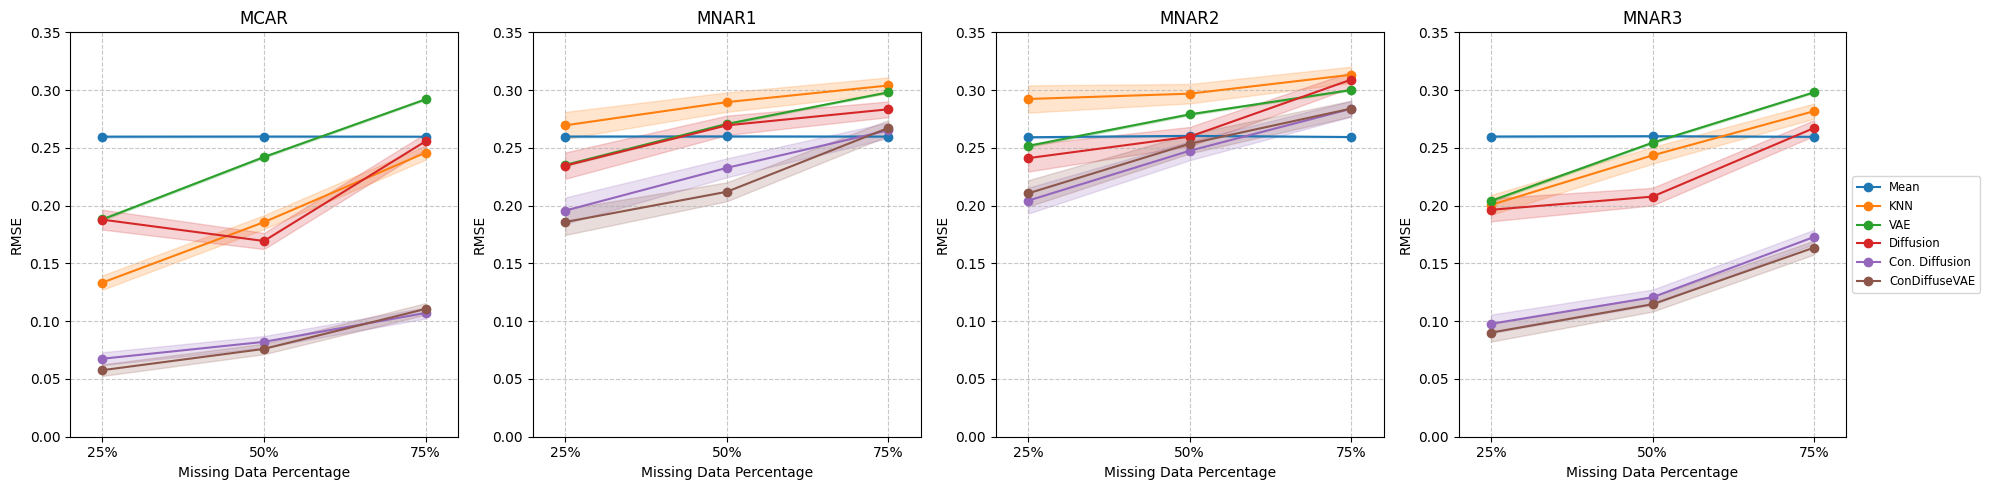

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def create_dataframe(data, missing_type):
    df = pd.DataFrame(data, columns=['Method', '25%', '25% CI', '50%', '50% CI', '75%', '75% CI'])
    df_melted = df.melt(id_vars=['Method'],
                        value_vars=['25%', '50%', '75%'],
                        var_name='Missing Data Percentage',
                        value_name='RMSE')
    df_melted['CI'] = df.melt(id_vars=['Method'],
                              value_vars=['25% CI', '50% CI', '75% CI'])['value']
    df_melted['Missing Type'] = missing_type
    return df_melted

mcar_data = [
    ['Mean', 0.2597, 0.0004, 0.2598, 0.0003, 0.2597, 0.0002],
    ['KNN', 0.1334, 0.0031, 0.1857, 0.0030, 0.2458, 0.0030],
    ['VAE', 0.1881, 0.0004, 0.2421, 0.0004, 0.2920, 0.0003],
    ['Diffusion', 0.1879, 0.0043, 0.1694, 0.0035, 0.2557, 0.0034],
    ['Con. Diffusion', 0.0675, 0.0028, 0.0821, 0.0025, 0.1071, 0.0024],
    ['ConDiffuseVAE', 0.0576, 0.0025, 0.0760, 0.0023, 0.1106, 0.0025]
]

mnar1_data = [
    ['Mean', 0.2598, 0.0004, 0.2599, 0.0003, 0.2598, 0.0002],
    ['KNN', 0.2695, 0.0058, 0.2896, 0.0042, 0.3040, 0.0035],
    ['VAE', 0.2352, 0.0005, 0.2707, 0.0004, 0.2981, 0.0003],
    ['Diffusion', 0.2346, 0.0057, 0.2695, 0.0042, 0.2834, 0.0034],
    ['Con. Diffusion', 0.1957, 0.0057, 0.2327, 0.0041, 0.2652, 0.0034],
    ['ConDiffuseVAE', 0.1858, 0.0056, 0.2120, 0.0041, 0.2673, 0.0034]
]

mnar2_data = [
    ['Mean', 0.2592, 0.0004, 0.2604, 0.0003, 0.2594, 0.0002],
    ['KNN', 0.2923, 0.0059, 0.2969, 0.0042, 0.3133, 0.0035],
    ['VAE', 0.2517, 0.0005, 0.2790, 0.0004, 0.3001, 0.0003],
    ['Diffusion', 0.2411, 0.0058, 0.2597, 0.0042, 0.3091, 0.0034],
    ['Con. Diffusion', 0.2043, 0.0056, 0.2475, 0.0041, 0.2839, 0.0034],
    ['ConDiffuseVAE', 0.2106, 0.0057, 0.2536, 0.0042, 0.2840, 0.0034]
]

mnar3_data = [
    ['Mean', 0.2598, 0.0004, 0.2601, 0.0003, 0.2596, 0.0002],
    ['KNN', 0.2006, 0.0043, 0.2435, 0.0036, 0.2818, 0.0033],
    ['VAE', 0.2041, 0.0005, 0.2545, 0.0004, 0.2981, 0.0003],
    ['Diffusion', 0.1964, 0.0050, 0.2078, 0.0038, 0.2672, 0.0034],
    ['Con. Diffusion', 0.0977, 0.0040, 0.1207, 0.0033, 0.1729, 0.0031],
    ['ConDiffuseVAE', 0.0901, 0.0039, 0.1147, 0.0032, 0.1637, 0.0030]
]

df_mcar = create_dataframe(mcar_data, 'MCAR')
df_mnar1 = create_dataframe(mnar1_data, 'MNAR1')
df_mnar2 = create_dataframe(mnar2_data, 'MNAR2')
df_mnar3 = create_dataframe(mnar3_data, 'MNAR3')

df_combined = pd.concat([df_mcar, df_mnar1, df_mnar2, df_mnar3])

fig, axs = plt.subplots(1, 4, figsize=(20, 5))

colors = {'Mean': '#1f77b4', 'KNN': '#ff7f0e', 'VAE': '#2ca02c',
          'Diffusion': '#d62728', 'Con. Diffusion': '#9467bd', 'ConDiffuseVAE': '#8c564b'}

x_values = [25, 50, 75]

for i, (missing_type, ax) in enumerate(zip(['MCAR', 'MNAR1', 'MNAR2', 'MNAR3'], axs.flatten())):
    data = df_combined[df_combined['Missing Type'] == missing_type]

    for method in colors.keys():
        method_data = data[data['Method'] == method]
        y_values = method_data['RMSE'].values
        ci_values = method_data['CI'].values

        ax.plot(x_values, y_values, '-o', label=method, color=colors[method])
        ax.fill_between(x_values,
                        y_values - 2*ci_values,
                        y_values + 2*ci_values,
                        alpha=0.2,
                        color=colors[method])

    ax.set_title(missing_type)
    ax.set_xlabel('Missing Data Percentage')
    ax.set_ylabel('RMSE')
    ax.set_ylim(0, 0.35)
    ax.set_xlim(20, 80)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_xticks(x_values)
    ax.set_xticklabels(['25%', '50%', '75%'])

# Add legend to the rightmost subplot
axs[-1].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')

plt.tight_layout()
plt.savefig('Results_summary.png', dpi=300, bbox_inches='tight')
plt.show()


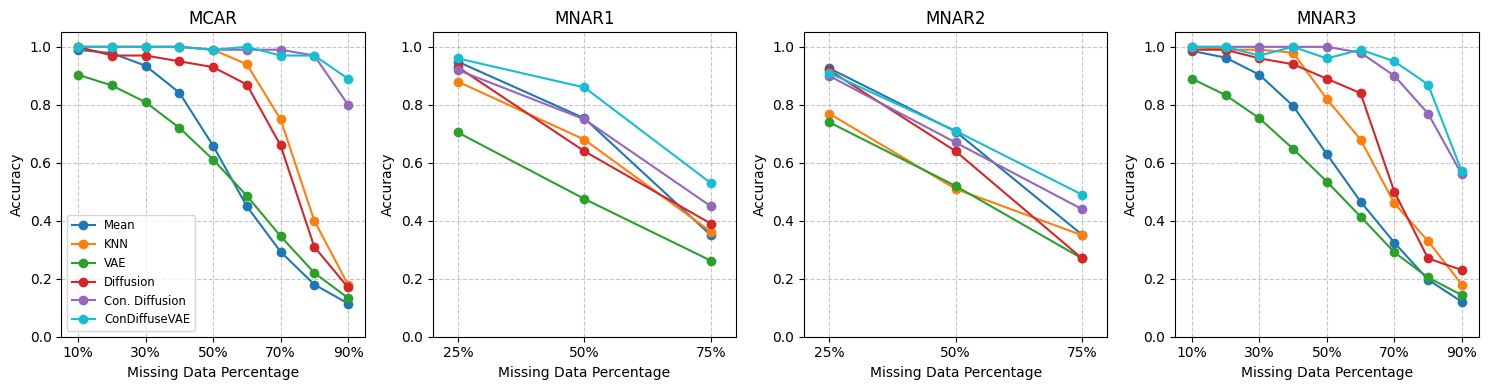

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def create_dataframe(data, missing_type, columns):
    df = pd.DataFrame(data, columns=['Method'] + columns)
    df_melted = df.melt(id_vars=['Method'],
                        var_name='Missing Data Percentage',
                        value_name='Accuracy')
    df_melted['Missing Type'] = missing_type
    return df_melted

mcar_data = [
    ['Mean', 0.9896, 0.9781, 0.9347, 0.8418, 0.6589, 0.4499, 0.2932, 0.1801, 0.1146],
    ['KNN', 1.0000, 1.0000, 1.0000, 1.0000, 0.9900, 0.9400, 0.7500, 0.4000, 0.1800],
    ['VAE', 0.9037, 0.8666, 0.8089, 0.7205, 0.6113, 0.4862, 0.3468, 0.2203, 0.1334],
    ['Diffusion', 1.0000, 0.9700, 0.9700, 0.9500, 0.9300, 0.8700, 0.6600, 0.3100, 0.1700],
    ['Con. Diffusion', 1.0000, 1.0000, 1.0000, 1.0000, 0.9900, 0.9900, 0.9900, 0.9700, 0.8000],
    ['ConDiffuseVAE', 1.0000, 1.0000, 1.0000, 1.0000, 0.9900, 1.0000, 0.9700, 0.9700, 0.8900]
]

mnar1_data = [
    ['Mean', 0.9488, 0.7535, 0.3500],
    ['KNN', 0.8800, 0.6800, 0.3623],
    ['VAE', 0.7046, 0.4754, 0.2623],
    ['Diffusion', 0.9300, 0.6400, 0.3900],
    ['Con. Diffusion', 0.9200, 0.7500, 0.4500],
    ['ConDiffuseVAE', 0.9600, 0.8600, 0.5300]
]

mnar2_data = [
    ['Mean', 0.9263, 0.7079, 0.3518],
    ['KNN', 0.7700, 0.5100, 0.3500],
    ['VAE', 0.7400, 0.5200, 0.2700],
    ['Diffusion', 0.9200, 0.6400, 0.2700],
    ['Con. Diffusion', 0.9000, 0.6700, 0.4400],
    ['ConDiffuseVAE', 0.9100, 0.7100, 0.4900]
]

mnar3_data = [
    ['Mean', 0.9860, 0.9627, 0.9038, 0.7961, 0.6299, 0.4659, 0.3246, 0.1969, 0.1206],
    ['KNN', 1.0000, 0.9900, 0.9900, 0.9800, 0.8200, 0.6800, 0.4600, 0.3300, 0.1800],
    ['VAE', 0.8899, 0.8334, 0.7535, 0.6480, 0.5350, 0.4141, 0.2913, 0.2044, 0.1435],
    ['Diffusion', 0.9900, 0.9900, 0.9600, 0.9400, 0.8900, 0.8400, 0.5000, 0.2700, 0.2300],
    ['Con. Diffusion', 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9800, 0.9000, 0.7700, 0.5600],
    ['ConDiffuseVAE', 1.0000, 1.0000, 0.9700, 1.0000, 0.9600, 0.9900, 0.9500, 0.8700, 0.5700]
]

mcar_columns = ['0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9']
mnar_columns = ['25%', '50%', '75%']

df_mcar = create_dataframe(mcar_data, 'MCAR', mcar_columns)
df_mnar1 = create_dataframe(mnar1_data, 'MNAR1', mnar_columns)
df_mnar2 = create_dataframe(mnar2_data, 'MNAR2', mnar_columns)
df_mnar3 = create_dataframe(mnar3_data, 'MNAR3', mcar_columns)

df_combined = pd.concat([df_mcar, df_mnar1, df_mnar2, df_mnar3])

fig, axs = plt.subplots(1, 4, figsize=(15, 4))

colors = {'Mean': '#1f77b4', 'KNN': '#ff7f0e', 'VAE': '#2ca02c',
          'Diffusion': '#d62728', 'Con. Diffusion': '#9467bd', 'ConDiffuseVAE': '#17becf'}

for i, (missing_type, ax) in enumerate(zip(['MCAR', 'MNAR1', 'MNAR2', 'MNAR3'], axs.flatten())):
    data = df_combined[df_combined['Missing Type'] == missing_type]

    for method in colors.keys():
        method_data = data[data['Method'] == method]
        x_values = method_data['Missing Data Percentage'].values
        y_values = method_data['Accuracy'].values

        if missing_type in ['MCAR', 'MNAR3']:
            x_values = x_values.astype(float)
        else:
            x_values = [0.25, 0.50, 0.75]  # Convert percentage strings to floats

        ax.plot(x_values, y_values, '-o', label=method, color=colors[method])

    ax.set_title(missing_type)
    ax.set_xlabel('Missing Data Percentage')
    ax.set_ylabel('Accuracy')
    ax.set_ylim(0, 1.05)
    ax.grid(True, linestyle='--', alpha=0.7)

    if missing_type in ['MCAR', 'MNAR3']:
        ax.set_xlim(0.05, 0.95)
        ax.set_xticks([0.1, 0.3, 0.5, 0.7, 0.9])
        ax.set_xticklabels(['10%', '30%', '50%', '70%', '90%'])
    else:
        ax.set_xlim(0.2, 0.8)
        ax.set_xticks([0.25, 0.50, 0.75])
        ax.set_xticklabels(['25%', '50%', '75%'])

# Add legend to the rightmost subplot (MNAR3)
axs[0].legend(loc='lower left', fontsize='small')

plt.tight_layout()
plt.savefig('Results_summary2.png',dpi=300)
plt.show()